# https://github.com/jbloomAus/DecisionTransformerInterpretability/issues/33


In [1]:
import wandb
run = wandb.init()
artifact = run.use_artifact('arena-ldn/PPO-MiniGrid/Test-PPO-LSTM_checkpoints:v16', type='model')
artifact_dir = artifact.download()

wandb: Currently logged in as: jbloomaus (arena-ldn). Use `wandb login --relogin` to force relogin


wandb:   11 of 11 files downloaded.  


In [3]:

import torch
import gymnasium as gym 
from src.environments.environments import make_env
from src.config import LSTMModelConfig, EnvironmentConfig, RunConfig, ConfigJsonEncoder
from src.ppo.agent import load_saved_checkpoint
from src.environments.registration import register_envs

register_envs()

path = "artifacts/Test-PPO-LSTM_checkpoints:v16/Test-PPO-LSTM_10.pt"
agent = load_saved_checkpoint(path, 10)


/Users/josephbloom/miniforge3/envs/decision_transformer_interpretability/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /Users/josephbloom/GithubRepositories/DecisionTransformerInterpretability/videos/test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [4]:
import plotly.express as px 
obs, info = agent.envs.reset()
render = agent.envs.envs[0].env.render()
px.imshow(render)

# Goals

1. Assess the checkpoint performance
- Report on the episodic return and episode lengths
2. Sample trajectories for training of the decision transformer model
- Generate a trajectory file



In [7]:
from src.utils import TrajectoryWriter
from src.config import RunConfig, OnlineTrainConfig
from src.ppo.memory import Memory

trajectory_writer = TrajectoryWriter(
    path = "./test.gz", 
    run_config=RunConfig(), 
    environment_config=agent.environment_config,
    online_config=OnlineTrainConfig(),
    model_config=agent.model_config)

memory = Memory(agent.envs, OnlineTrainConfig(num_envs=15), device = agent.device)
agent.rollout(memory, 2000, agent.envs, trajectory_writer)
trajectory_writer.tag_terminated_trajectories()
trajectory_writer.write(upload_to_wandb=False)

Writing to ./test.gz, using gzip compression
Trajectory written to ./test.gz


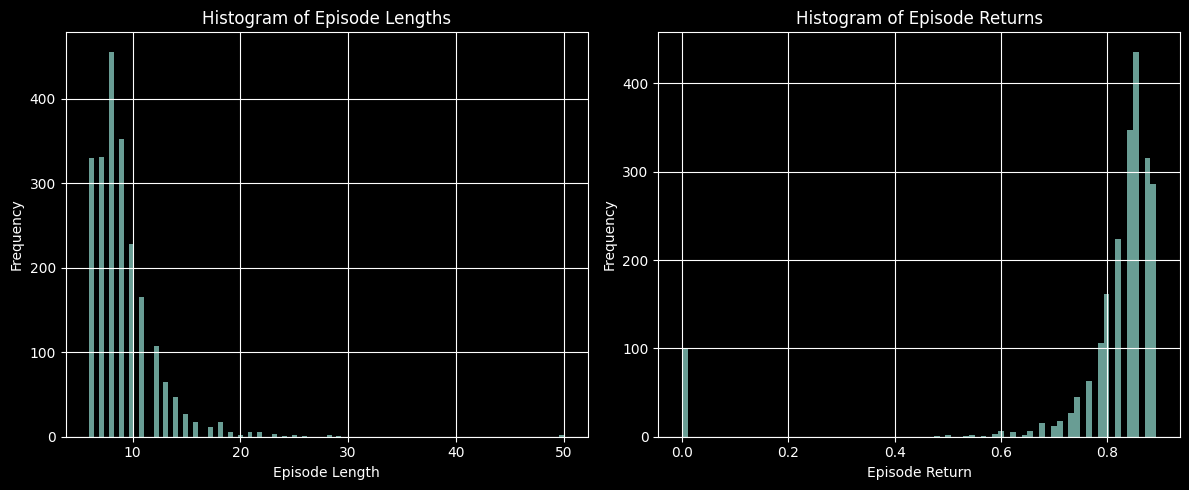

In [8]:
import plotly.express as px 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def process_memory_vars_to_log(memory_vars_to_log):
    # Convert defaultdict to dictionary
    memory_dict = dict(memory_vars_to_log)

    # Flatten the nested dictionary and prepare data for DataFrame
    data = []
    for key, value in memory_dict.items():
        episode_length = value['episode_length'][0]
        episode_return = value['episode_return'][0]
        data.append([key, episode_length, episode_return])

    # Create a DataFrame with columns 'id', 'episode_length', and 'episode_return'
    df = pd.DataFrame(data, columns=['id', 'episode_length', 'episode_return'])

    return df

def create_histograms(df):
    # Create a 1x2 grid of subplots for the histograms
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Create a histogram for the 'episode_length' column
    axs[0].hist(df['episode_length'], bins='auto', alpha=0.75)
    axs[0].set_xlabel('Episode Length')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('Histogram of Episode Lengths')
    axs[0].grid(True)

    # Create a histogram for the 'episode_return' column
    axs[1].hist(df['episode_return'], bins='auto', alpha=0.75)
    axs[1].set_xlabel('Episode Return')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Histogram of Episode Returns')
    axs[1].grid(True)

    # Adjust the layout and display the histograms
    plt.tight_layout()
    plt.show()

df = process_memory_vars_to_log(memory.vars_to_log)
create_histograms(df)

In [9]:
import os

def load_all_agents_from_checkpoints(checkpoint_folder_path):
    # Get all files in the checkpoint folder
    checkpoint_files = os.listdir(checkpoint_folder_path)

    # Filter out non-checkpoint files
    checkpoint_files = [f for f in checkpoint_files if f.endswith('.pt')]

    # Load each checkpoint into an agent
    agents = []
    for checkpoint_file in checkpoint_files:
        path = os.path.join(checkpoint_folder_path, checkpoint_file)
        agent = load_saved_checkpoint(path, 10)
        agents.append(agent)

    return agents

checkpoint_folder_path = "artifacts/Test-PPO-LSTM_checkpoints:v16"
agents = load_all_agents_from_checkpoints(checkpoint_folder_path)

/Users/josephbloom/miniforge3/envs/decision_transformer_interpretability/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning:

WARN: Overwriting existing videos at /Users/josephbloom/GithubRepositories/DecisionTransformerInterpretability/videos/test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)



In [63]:
def sample_from_agents(agents, rollout_length=2000, trajectory_path=None, num_envs=1):
    all_episode_lengths = []
    all_episode_returns = []

    # Sample rollouts from each agent
    for i, agent in enumerate(agents):
        memory = Memory(agent.envs, OnlineTrainConfig(num_envs=num_envs), device=agent.device)
        if trajectory_path:
            trajectory_writer = TrajectoryWriter(
                path=os.path.join(trajectory_path, f"rollouts_agent_{i}.gz"),
                run_config=RunConfig(track=False),
                environment_config=agent.environment_config,
                online_config=OnlineTrainConfig(num_envs=num_envs),
                model_config=agent.model_config
            )
        else:
            trajectory_writer = None
        agent.rollout(memory, rollout_length, agent.envs, trajectory_writer)
        if trajectory_writer:
            trajectory_writer.tag_terminated_trajectories()
            trajectory_writer.write(upload_to_wandb=False)

        # Process the episode lengths and returns
        df = process_memory_vars_to_log(memory.vars_to_log)
        all_episode_lengths.append(df['episode_length'])
        all_episode_returns.append(df['episode_return'])


    return all_episode_lengths, all_episode_returns

import pandas as pd
import plotly.graph_objects as go

def plot_checkpoints_stats(all_episode_lengths, all_episode_returns):

    # stack df's but label them with the agent number
    lengths = pd.concat(all_episode_lengths, keys=range(len(all_episode_lengths))).reset_index(level=0, drop=False)
    # rename level 0 to checkpoint
    lengths = lengths.rename(columns={'level_0': 'checkpoint'})

    # Compute mean and std of episode lengths
    length_stats = lengths.groupby('checkpoint')['episode_length'].agg(['mean', 'std']).reset_index()

    # histogram of all episode lengths
    fig1 = go.Figure()
    for idx, stats in length_stats.iterrows():
        fig1.add_trace(go.Box(y=lengths[lengths['checkpoint'] == stats['checkpoint']]['episode_length'],
                              name=f"{stats['checkpoint']}: ({stats['mean']:.2f}, +- {stats['std']:.2f})",
                              boxpoints='all', jitter=0.3, pointpos=-1.8))

    fig1.update_layout(title='Episode Lengths')

    # stack df's but label them with the agent number
    returns = pd.concat(all_episode_returns, keys=range(len(all_episode_lengths))).reset_index(level=0, drop=False)
    # rename level 0 to checkpoint
    returns = returns.rename(columns={'level_0': 'checkpoint'})

    # Compute mean and std of episode returns
    return_stats = returns.groupby('checkpoint')['episode_return'].agg(['mean', 'std']).reset_index()

    # histogram of all episode lengths
    fig2 = go.Figure()
    for idx, stats in return_stats.iterrows():
        fig2.add_trace(go.Box(y=returns[returns['checkpoint'] == stats['checkpoint']]['episode_return'],
                              name=f"{stats['checkpoint']}: ({stats['mean']:.2f}, +- {stats['std']:.2f})",
                              boxpoints='all', jitter=0.3, pointpos=-1.8))

    fig2.update_layout(title='Episode Returns')

    return fig1, fig2

checkpoint_folder_path = "artifacts/Test-PPO-LSTM_checkpoints:v16"
agents = load_all_agents_from_checkpoints(checkpoint_folder_path)

trajectory_path = "rollouts"
num_envs = 5
# all_episode_lengths, all_episode_returns = sample_from_agents(agents, rollout_length=2000, trajectory_path=trajectory_path, num_envs=num_envs)
fig1, fig2 = plot_checkpoints_stats(all_episode_lengths, all_episode_returns)
fig1.show()
fig2.show()

/Users/josephbloom/miniforge3/envs/decision_transformer_interpretability/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning:

WARN: Overwriting existing videos at /Users/josephbloom/GithubRepositories/DecisionTransformerInterpretability/videos/test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)

